In [ ]:
import pennylane as qml
from pennylane import qchem
from pennylane import numpy as np
from itertools import chain
import time
import re
from scipy.optimize import minimize
ash_excitation = []
energies = []
excitations= []

X = qml.PauliX
Y = qml.PauliY
Z = qml.PauliZ
I = qml.Identity



bond_length = 3.0
symbols = ["H","H","H","H"]
electrons = 4
orbitals = 8

#symbols = ["Li", "H"]
r_bohr = bond_length *1.8897259886  
coordinates = np.array([[0.0,0.0, 1*r_bohr], [0.0, 0.0, 2*r_bohr], [0.0,0.0,3*r_bohr],[0.0, 0.0, 4*r_bohr]])
#coordinates = np.array([[0.0,0.0, 0*r_bohr], [0.0, 0.0, 1*r_bohr]])
# Calculation of the Hamiltonian
H, qubits = qml.qchem.molecular_hamiltonian(symbols, coordinates, basis="sto-6g", method="pyscf")

hf_state = qchem.hf_state(electrons, qubits)
#Calculation of HF state
dev = qml.device("lightning.qubit", wires=qubits)
@qml.qnode(dev)
def circuit(hf_state, electrons, qubits, H):
    # Prepare the Hartree-Fock state
    print('Updated hf_state is', hf_state)  
    qml.BasisState(hf_state, wires=range(qubits))
    return qml.expval(H)   #Calculating the expectation value of the Hamiltonian

# Commutator calculation for HF state
dev = qml.device("lightning.qubit", wires=qubits)
@qml.qnode(dev)
def commutator_0(H,w, k):  #H is the Hamiltonian, w is the operator, k is the basis state - HF state
    qml.BasisState(k, wires=range(qubits))
    res = qml.commutator(H, w)   #Calculating the commutator
    return qml.expval(res)

# Commutator calculation for other states except HF state
dev = qml.device("lightning.qubit", wires=qubits)
@qml.qnode(dev)
def commutator_1(H,w, k): #H is the Hamiltonian, w is the operator, k is the basis state
    qml.StatePrep(k, wires=range(qubits))
    res = qml.commutator(H, w) #Calculating the commutator
    return qml.expval(res)

# Energy calculation 
dev = qml.device("lightning.qubit", wires=qubits)
@qml.qnode(dev)
def ash(params, ash_excitation, hf_state, qubits, H):
    #qml.BasisState(hf_state, wires=range(qubits))
    [qml.PauliX(i) for i in np.nonzero(hf_state)[0]]  #Appln of HF state
    for i, excitation in enumerate(ash_excitation):
        if len(ash_excitation[i]) == 4:
            qml.FermionicDoubleExcitation(weight=params[i], wires1=ash_excitation[i][2:][::-1], wires2=ash_excitation[i][:2][::-1])
        elif len(ash_excitation[i]) == 2:
            #print('Single Exc going in is', ash_excitation[i])
            qml.FermionicSingleExcitation(weight=params[i], wires=list(range(ash_excitation[i][0], ash_excitation[i][1] + 1)))

    return qml.expval(H)  #Calculating the expectation value of the Hamiltonian

# Calculation of New state, same as the above function but with the state return

dev = qml.device("lightning.qubit", wires=qubits)
@qml.qnode(dev)
def new_state(hf_state, ash_excitation, params):
    #qml.BasisState(hf_state, wires=range(qubits))
    [qml.PauliX(i) for i in np.nonzero(hf_state)[0]] #Applying the HF state
    for i, excitations in enumerate(ash_excitation):
        if len(ash_excitation[i]) == 4:
            print('Exc. dealing right now is', ash_excitation[i])
            print('The params that are going in', params[i])
            qml.FermionicDoubleExcitation(weight=params[i], wires1=ash_excitation[i][2:][::-1], wires2=ash_excitation[i][:2][::-1])

        elif len(ash_excitation[i]) == 2:
            print('Single Exc. dealing right now is', ash_excitation[i])
            print('Single exc params that are going in', params[i])
            qml.FermionicSingleExcitation(weight=params[i], wires=list(range(ash_excitation[i][0], ash_excitation[i][1] + 1)))

    return qml.state()

def cost(params):
    energy = ash(params, ash_excitation, hf_state, qubits, H)
    return energy

def callback(params):
    print(f"Current parameters: {params}")
    print(f"Current cost: {cost(params)}\n")

def adaptvqe(H, hf_state, electrons, qubits,a_it=1):
    print('HF state is', circuit(hf_state, electrons, qubits, H))
    singles, doubles = qml.qchem.excitations(electrons, orbitals)
    optimizer = qml.GradientDescentOptimizer(stepsize=0.5)  #Optimizer
    op1 =  [qml.fermi.FermiWord({(0, x[0]): "+", (1, x[1]): "-"}) for x in singles]
    op2 =  [qml.fermi.FermiWord({(0, x[0]): "+", (1, x[1]): "+", (2, x[2]): "-", (3, x[3]): "-"})for x in doubles]
    #print('Singles are', op1)
    #print('Doubles:', op2)
    operator_pool = (op1) + (op2)  #Operator pool - Singles and Doubles
    states = [hf_state]


    for j in range(a_it):
        print('The adapt iteration now is', j)  #Adapt iteration
        max_value = float('-inf')
        max_operator = None
        # Start with the most recent state (last state in the list)
        k = states[-1] if states else hf_state  # if states is empty, fall back to hf_state

        for i in operator_pool:
            print('The current excitation operator is', i)   #Current excitation operator - fermionic one
            w = qml.fermi.jordan_wigner(i)  #JW transformation
            if np.array_equal(k, hf_state): # If the current state is the HF state
                print('Print, if this is activated - HF state')
                current_value = abs(2*(commutator_0(H, w, k)))      #Commutator calculation is activated  
            else:
                current_value = abs(2*(commutator_1(H, w, k)))      #For other states, commutator calculation is activated
            print(f'The expectation value of {i} is', current_value)

            if current_value > max_value:
                max_value = current_value
                max_operator = i

        print(f"The highest operator value is {max_value} for operator {max_operator}")  #Highest operator value

        # Convert operator to excitations and append to ash_excitation
        indices_str = re.findall(r'\d+', str(max_operator))
        excitations = [int(index) for index in indices_str]
        print('Highest gradient excitation is', excitations)
        ash_excitation.append(excitations) #Appending the excitations to the ash_excitation
        print('The current status of ash_excitation is', ash_excitation)
        print('Moving towards parameters')
        params = np.zeros(len(ash_excitation), requires_grad=True)  #Parameters initialization
        print('The length of parameters is', params)


        #Energy calculation
        result = minimize(cost, params, method='powell', callback=callback, tol = 1e-12, options = {'disp': True, 'maxiter': 1e8})

        print("Final updated parameters:", result.x)
        print("Final cost:", result.fun)

        params= (result.x)
        energies.append(result.fun)
        print('Updated params are', params)
        print('Updated excitation are', ash_excitation)

        # New state generation - With the updated parameters
        ostate = new_state(hf_state, ash_excitation, params)
        print(qml.draw(new_state, max_length=100)(hf_state,ash_excitation,params))
        #print('The updated state is', ostate)
        # Append the new state to the states list
        states.append(ostate)

    return energies, params




## Function definition - Updated the recycled parameters

In [2]:
import pennylane as qml
from pennylane import qchem
from pennylane import numpy as np
from itertools import chain
import time
import re
from scipy.optimize import minimize
ash_excitation = []
energies = []
excitations= []

X = qml.PauliX
Y = qml.PauliY
Z = qml.PauliZ
I = qml.Identity



bond_length = 3.0
symbols = ["H","H","H","H"]
electrons = 4
orbitals = 8
r_bohr = bond_length *1.8897259886  
coordinates = np.array([[0.0,0.0, 1*r_bohr], [0.0, 0.0, 2*r_bohr], [0.0,0.0,3*r_bohr],[0.0, 0.0, 4*r_bohr]])
H, qubits = qml.qchem.molecular_hamiltonian(symbols, coordinates, basis="sto-6g", method="pyscf")
hf_state = qchem.hf_state(electrons, qubits)




def adaptvqesri(adapt_it, e_th):
    #Calculation of HF state
    dev = qml.device("lightning.qubit", wires=qubits)
    @qml.qnode(dev)
    def circuit(hf_state, electrons, qubits, H):
        print('Updated hf_state is', hf_state)  
        qml.BasisState(hf_state, wires=range(qubits))
        return qml.expval(H)   #Calculating the expectation value of the Hamiltonian
    
    # Commutator calculation for HF state
    @qml.qnode(dev)
    def commutator_0(H,w, k):  #H is the Hamiltonian, w is the operator, k is the basis state - HF state
        qml.BasisState(k, wires=range(qubits))
        res = qml.commutator(H, w)   #Calculating the commutator
        return qml.expval(res)
    
    # Commutator calculation for other states except HF state
    @qml.qnode(dev)
    def commutator_1(H,w, k): #H is the Hamiltonian, w is the operator, k is the basis state
        qml.StatePrep(k, wires=range(qubits))
        res = qml.commutator(H, w) #Calculating the commutator
        return qml.expval(res)

    #Energy calculation 
    @qml.qnode(dev)
    def ash(params, ash_excitation, hf_state, H):
        [qml.PauliX(i) for i in np.nonzero(hf_state)[0]]  #Appln of HF state
        for i, excitation in enumerate(ash_excitation):
            if len(ash_excitation[i]) == 4:
                qml.FermionicDoubleExcitation(weight=params[i], wires1=ash_excitation[i][2:][::-1], wires2=ash_excitation[i][:2][::-1])
            elif len(ash_excitation[i]) == 2:
                qml.FermionicSingleExcitation(weight=params[i], wires=list(range(ash_excitation[i][0], ash_excitation[i][1] + 1)))
        return qml.expval(H)  #Calculating the expectation value of the Hamiltonian
    
    # Calculation of New state, same as the above function but with the state return
    dev1 = qml.device("lightning.qubit", wires=qubits)
    @qml.qnode(dev1)
    def new_state(hf_state, ash_excitation, params):
        [qml.PauliX(i) for i in np.nonzero(hf_state)[0]] #Applying the HF state
        for i, excitations in enumerate(ash_excitation):
            if len(ash_excitation[i]) == 4:
                print('Exc. dealing right now is', ash_excitation[i])
                print('The params that are going in', params[i])
                qml.FermionicDoubleExcitation(weight=params[i], wires1=ash_excitation[i][2:][::-1], wires2=ash_excitation[i][:2][::-1])
            elif len(ash_excitation[i]) == 2:
                print('Single Exc. dealing right now is', ash_excitation[i])
                print('Single exc params that are going in', params[i])
                qml.FermionicSingleExcitation(weight=params[i], wires=list(range(ash_excitation[i][0], ash_excitation[i][1] + 1)))
        return qml.state()
    
    def cost(params):
        energy = ash(params, ash_excitation, hf_state, H)
        return energy

    def callback(params):
        print(f"Current parameters: {params}")
        print(f"Current cost: {cost(params)}\n")
    

    print('HF state is', circuit(hf_state, electrons, qubits, H))
    singles, doubles = qml.qchem.excitations(electrons, orbitals)
    op1 =  [qml.fermi.FermiWord({(0, x[0]): "+", (1, x[1]): "-"}) for x in singles]
    op2 =  [qml.fermi.FermiWord({(0, x[0]): "+", (1, x[1]): "+", (2, x[2]): "-", (3, x[3]): "-"})for x in doubles]
    operator_pool = (op1) + (op2)  #Operator pool - Singles and Doubles
    states = [hf_state]
    params = np.zeros(len(ash_excitation), requires_grad=True) 
    

    for j in range(adapt_it):
        print('The adapt iteration now is', j)  #Adapt iteration
        max_value = float('-inf')
        max_operator = None
        # Start with the most recent state (last state in the list)
        k = states[-1] if states else hf_state  # if states is empty, fall back to hf_state
       
        for i in operator_pool:
            print('The current excitation operator is', i)   #Current excitation operator - fermionic one
            w = qml.fermi.jordan_wigner(i)  #JW transformation
            if np.array_equal(k, hf_state): # If the current state is the HF state
                print('Print, if this is activated - HF state')
                current_value = abs(2*(commutator_0(H, w, k)))      #Commutator calculation is activated  
            else:
                current_value = abs(2*(commutator_1(H, w, k)))      #For other states, commutator calculation is activated
            print(f'The expectation value of {i} is', current_value)

            if current_value > max_value:
                max_value = current_value
                max_operator = i

        print(f"The highest operator value is {max_value} for operator {max_operator}")  #Highest operator value

        # Convert operator to excitations and append to ash_excitation
        indices_str = re.findall(r'\d+', str(max_operator))
        excitations = [int(index) for index in indices_str]
        print('Highest gradient excitation is', excitations)
        ash_excitation.append(excitations) #Appending the excitations to the ash_excitation
        print('The current status of ash_excitation is', ash_excitation)
        print('Moving towards parameters')
         #Parameters initialization
        params = np.append(params, 0.0)  #Parameters initialization
        print('The length of parameters is', params)


        #Energy calculation
        result = minimize(cost, params, method='powell', callback=callback, tol = e_th, options = {'disp': True, 'maxiter': 1e8})

        print("Final updated parameters:", result.x)
        print("Final cost:", result.fun)

        params= (result.x)
        energies.append(result.fun)
        print('Updated params are', params)
        print('Updated excitation are', ash_excitation)

        # New state generation - With the updated parameters
        ostate = new_state(hf_state, ash_excitation, params)
        print(qml.draw(new_state, max_length=100)(hf_state,ash_excitation,params))
        # Append the new state to the states list
        states.append(ostate)

    return energies, params, ash_excitation




In [ ]:
adaptvqesri(adapt_it=5, e_th=1e-12)

Updated hf_state is [1 1 1 1 0 0 0 0]
HF state is -1.332568888066893
The adapt iteration now is 0
The current excitation operator is a⁺(0) a(4)
Print, if this is activated - HF state
The expectation value of a⁺(0) a(4) is 9.258181025983969e-08
The current excitation operator is a⁺(0) a(6)
Print, if this is activated - HF state
The expectation value of a⁺(0) a(6) is 0.0
The current excitation operator is a⁺(1) a(5)
Print, if this is activated - HF state
The expectation value of a⁺(1) a(5) is 9.258181027371748e-08
The current excitation operator is a⁺(1) a(7)
Print, if this is activated - HF state
The expectation value of a⁺(1) a(7) is 0.0
The current excitation operator is a⁺(2) a(4)
Print, if this is activated - HF state
The expectation value of a⁺(2) a(4) is 0.0
The current excitation operator is a⁺(2) a(6)
Print, if this is activated - HF state
The expectation value of a⁺(2) a(6) is 1.1698968021417455e-07
The current excitation operator is a⁺(3) a(5)
Print, if this is activated - HF 

/Users/s.poyyapakkam/miniconda3/envs/sri/lib/python3.12/site-packages/pennylane_lightning/core/_serialize.py:353: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)


The expectation value of a⁺(0) a⁺(1) a(5) a(6) is 0.0
The current excitation operator is a⁺(0) a⁺(1) a(6) a(7)
Print, if this is activated - HF state
The expectation value of a⁺(0) a⁺(1) a(6) a(7) is 0.28410686098083854
The current excitation operator is a⁺(0) a⁺(2) a(4) a(6)
Print, if this is activated - HF state
The expectation value of a⁺(0) a⁺(2) a(4) a(6) is 0.030544625693072067
The current excitation operator is a⁺(0) a⁺(3) a(4) a(5)
Print, if this is activated - HF state
The expectation value of a⁺(0) a⁺(3) a(4) a(5) is 0.0
The current excitation operator is a⁺(0) a⁺(3) a(4) a(7)
Print, if this is activated - HF state
The expectation value of a⁺(0) a⁺(3) a(4) a(7) is 0.3078190525120401
The current excitation operator is a⁺(0) a⁺(3) a(5) a(6)
Print, if this is activated - HF state
The expectation value of a⁺(0) a⁺(3) a(5) a(6) is 0.277274426818968
The current excitation operator is a⁺(0) a⁺(3) a(6) a(7)
Print, if this is activated - HF state
The expectation value of a⁺(0) a⁺(3) a

([-1.4300836708403402,
  -1.5694603835520677,
  -1.7436334426149698,
  -1.8421101514362364,
  -1.8504359363275726],
 array([-0.83013641, -1.28923815, -1.01540767, -1.16553372,  0.28114359]),
 [[2, 3, 6, 7], [0, 3, 5, 6], [0, 1, 4, 5], [1, 2, 4, 7], [1, 5]])

## Powell - 21 Parameters 

In [3]:
adaptvqesri(adapt_it=21, e_th=1e-12)

Updated hf_state is [1 1 1 1 0 0 0 0]
HF state is -1.332568888066893
The adapt iteration now is 0
The current excitation operator is a⁺(0) a(4)
Print, if this is activated - HF state
The expectation value of a⁺(0) a(4) is 9.258181025983969e-08
The current excitation operator is a⁺(0) a(6)
Print, if this is activated - HF state
The expectation value of a⁺(0) a(6) is 0.0
The current excitation operator is a⁺(1) a(5)
Print, if this is activated - HF state
The expectation value of a⁺(1) a(5) is 9.258181027371748e-08
The current excitation operator is a⁺(1) a(7)
Print, if this is activated - HF state
The expectation value of a⁺(1) a(7) is 0.0
The current excitation operator is a⁺(2) a(4)
Print, if this is activated - HF state
The expectation value of a⁺(2) a(4) is 0.0
The current excitation operator is a⁺(2) a(6)
Print, if this is activated - HF state
The expectation value of a⁺(2) a(6) is 1.1698968021417455e-07
The current excitation operator is a⁺(3) a(5)
Print, if this is activated - HF 

/Users/s.poyyapakkam/miniconda3/envs/sri/lib/python3.12/site-packages/pennylane_lightning/core/_serialize.py:353: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)


The expectation value of a⁺(0) a⁺(1) a(5) a(6) is 0.0
The current excitation operator is a⁺(0) a⁺(1) a(6) a(7)
Print, if this is activated - HF state
The expectation value of a⁺(0) a⁺(1) a(6) a(7) is 0.28410686098083854
The current excitation operator is a⁺(0) a⁺(2) a(4) a(6)
Print, if this is activated - HF state
The expectation value of a⁺(0) a⁺(2) a(4) a(6) is 0.030544625693072067
The current excitation operator is a⁺(0) a⁺(3) a(4) a(5)
Print, if this is activated - HF state
The expectation value of a⁺(0) a⁺(3) a(4) a(5) is 0.0
The current excitation operator is a⁺(0) a⁺(3) a(4) a(7)
Print, if this is activated - HF state
The expectation value of a⁺(0) a⁺(3) a(4) a(7) is 0.3078190525120401
The current excitation operator is a⁺(0) a⁺(3) a(5) a(6)
Print, if this is activated - HF state
The expectation value of a⁺(0) a⁺(3) a(5) a(6) is 0.277274426818968
The current excitation operator is a⁺(0) a⁺(3) a(6) a(7)
Print, if this is activated - HF state
The expectation value of a⁺(0) a⁺(3) a

([-1.4300836708403402,
  -1.5694603835520677,
  -1.7436334426149698,
  -1.8421101514362364,
  -1.8504359363275726,
  -1.8594600250247684,
  -1.8656767410817476,
  -1.8663879748309666,
  -1.884356033007819,
  -1.8844361654314306,
  -1.8844361671921899,
  -1.8844364522332315,
  -1.8844364556758229,
  -1.8844365760316029,
  -1.884436576484849,
  -1.8844612572187276,
  -1.885096631853509,
  -1.885097395511084,
  -1.8850973962695554,
  -1.885123539547584,
  -1.885123539730992],
 array([-1.29108267e+00, -1.00837296e+00, -1.39465612e+00, -7.48122574e-01,
         1.54032144e+00,  1.48424826e+00, -1.42950905e+00,  1.33047435e+00,
        -1.45752777e+00,  1.32872193e+00, -8.66789328e-01, -9.26009670e-01,
         1.60238752e+00,  1.60069689e+00,  6.25660462e+00,  3.26534068e+00,
         6.02638401e-01, -3.33802336e-02, -3.12905473e+00,  1.45033785e-01,
        -4.29568968e-05]),
 [[2, 3, 6, 7],
  [0, 3, 5, 6],
  [0, 1, 4, 5],
  [1, 2, 4, 7],
  [1, 5],
  [2, 6],
  [3, 7],
  [2, 3, 6, 7],
  [0,

In [18]:
print(energies)

[-1.4300836708403402, -1.5694603835520677, -1.7436334426149698, -1.8421101514362364, -1.8504359363275726, -1.8594600250247684, -1.8656767410817476, -1.8663879748309666, -1.884356033007819, -1.8844361654314306, -1.8844361671921899, -1.8844364522332315, -1.8844364556758229, -1.8844365760316029, -1.884436576484849, -1.8844612572187276, -1.885096631853509, -1.885097395511084, -1.8850973962695554, -1.885123539547584, -1.885123539730992]


## Gradients - Exact vs Shots

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]


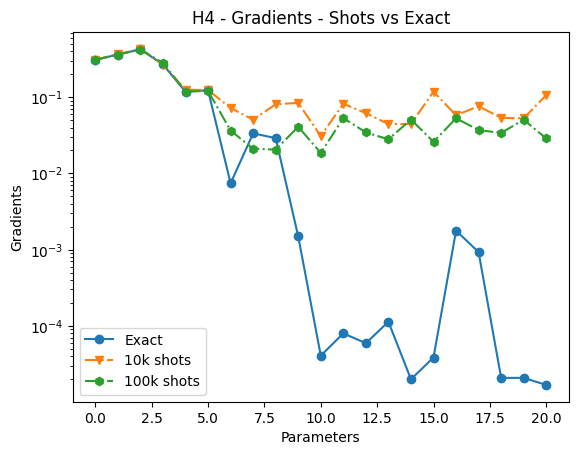

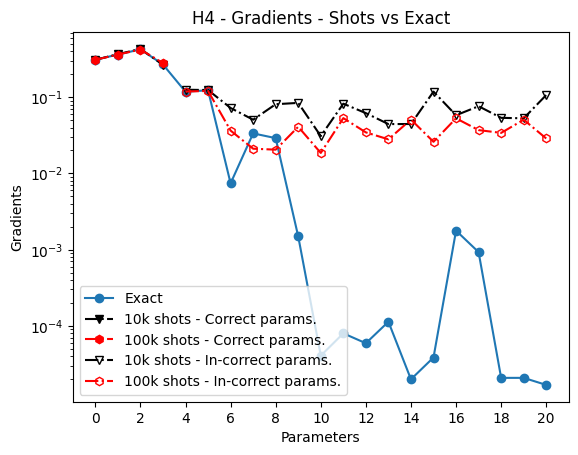

In [101]:
import numpy as np
params = []
for k in range(21):
    params.append(k)

print(params)

G_Exact = np.array([0.3100451588582116 , 0.36333417728273754, 0.4247574417703076, 0.2689421354231678, 0.11800197933700611, 0.12345368822802208,
              0.007420281812857612, 0.03354563739855884 , 0.029061752158627868, 0.0014907673809587962, 4.058027986704677e-05, 7.976896690634755e-05,
               5.913441683514514e-05, 0.00011328401551519846, 1.989246929409716e-05, 3.843530082175278e-05,  0.0017755760879906296, 0.0009282356568736209,
                 2.0769533991756538e-05, 2.0776790979757515e-05,1.678514206528755e-05])

G_100k = np.array([0.31012233368556263, 0.36278153764485294, 0.4224954854006534 , 0.28153706300448905, 0.11874528439791214, 0.12091574177009903,
                  0.036496747329089814, 0.021113196148753528, 0.020510792058557496, 0.04093571514178557, 0.01856540574468836, 0.053177591263377365,
                  0.03457620605522451, 0.02801950135618726, 0.050944905880169374, 0.02601220513310512 , 0.05287811195945368, 0.03704241195091213,
                  0.03403801969187872, 0.0506735825987322, 0.028745987022101658])  #Powell - 100k shots - 0th iteration

G_10k = np.array([0.3099162431306309, 0.36686751091589886 , 0.4303872599459001, 0.26664492219594843,0.12542908670332384, 0.1243034054423584,
                  0.07227267823768933, 0.050733283680761736, 0.08093960390932564, 0.08428620993570457, 0.030903952492093528, 0.0822684282601312,
                  0.061834972747899175, 0.04443504550103138, 0.04451098756987766, 0.11852872186034469, 0.05802126112805322, 0.07620382263558934,
                  0.05366141510645424, 0.052880135251468355,  0.106829094059067]) #Powell - 10k shots - 0th iteration

import matplotlib.pyplot as plt
plt.plot(params, G_Exact, '-o', label = 'Exact')
plt.plot(params, G_10k, '-.v', label = '10k shots')
plt.plot(params, G_100k, '-.h', label = '100k shots')
plt.legend()
plt.yscale('log')

plt.xlabel('Parameters')
plt.title('H4 - Gradients - Shots vs Exact')
plt.ylabel('Gradients')
plt.show()

plt.plot(params, G_Exact, '-o', label = 'Exact')
plt.plot(params[:4], G_10k[:4],  '-.v', color='k', label='10k shots - Correct params.')
plt.plot(params[:4], G_100k[:4],  '-.h', color='r', label='100k shots - Correct params.')
plt.plot(params[4:], G_10k[4:],  '-.v', color='k', markerfacecolor='none',label='10k shots - In-correct params.')
plt.plot(params[4:], G_100k[4:],  '-.h', color='r', markerfacecolor='none', label='100k shots - In-correct params.')
plt.legend()
plt.yscale('log')
plt.xticks(np.arange(0, 22, 2)) 
plt.xlabel('Parameters')
plt.title('H4 - Gradients - Shots vs Exact')
plt.ylabel('Gradients')
plt.show()

## Energy - Shots vs Exact

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]


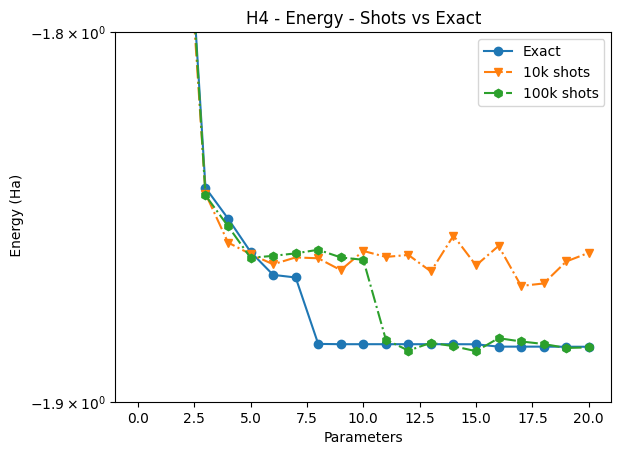

In [31]:
import numpy as np
params = []
for k in range(21):
    params.append(k)

print(params)

E_exact = np.array([-1.4300836708403402, -1.5694603835520677, -1.7436334426149698, -1.8421101514362364, -1.8504359363275726, -1.8594600250247684, 
                    -1.8656767410817476, -1.8663879748309666, -1.884356033007819, -1.8844361654314306, -1.8844361671921899, -1.8844364522332315, 
                    -1.8844364556758229, -1.8844365760316029, -1.884436576484849, -1.8844612572187276, -1.885096631853509, -1.885097395511084, 
                    -1.8850973962695554, -1.885123539547584, -1.885123539730992])

E_100k = np.array([-1.431464387461462, -1.5706137840445968, -1.7445154292149, -1.844173238851841, -1.8524862425248212, -1.8610473845425686,
                    -1.8605410002761278, -1.8598552535070012, -1.8588853857612926, -1.8609569752901267,  -1.861604086709718, -1.8831889197982379,
                    -1.8861726774026286,-1.8840488019855615, -1.8849791250167156,  -1.88632288156302, -1.8828073690834548, -1.883695972101264,
                      -1.884379016297748, -1.8854498416713266, -1.885303132220318]) #Powell - 100k shots - 1st iteration

E_100k1 = np.array([-1.4314606079236005,-1.5713046274227158,  -1.744744624339305, -1.8440418744811005,-1.851417399353439, -1.8613720708915669,
                    -1.8617680552763938, -1.8607818655703572,-1.8599335440388962, -1.8614656614212948,  -1.8595372612740584, -1.8608650142483987,
                    -1.8599291289619784, -1.859387197802784, -1.8607535366278023, -1.8586276461372815, -1.8642916275997419, -1.8732667587433893,
                    -1.8757460322487636,  -1.8795162160777772, -1.8828801422808312]) #Powell - 100k shots - 0th iteration

E_10k = np.array([-1.4351673889352257, -1.5651991504418161, -1.751469123615361, -1.8436952594174199, -1.8569282898247246, -1.8600672216690162,
                   -1.8628077792693236, -1.8609601988065476, -1.8611885481633914, -1.8643987945828824, -1.859208081363875,-1.8608238017901975,
                   -1.8602877158680589, -1.8647583024593826, -1.8550588122073244, -1.8631195449319817, -1.8578492010166685, -1.8686697660828904,
                   -1.868002835086847,-1.8620610309226926,  -1.859707949605153]) #Powell - 10k shots - 0th iteration


import matplotlib.pyplot as plt
plt.plot(params, E_exact, '-o', label = 'Exact')
plt.plot(params, E_10k, '-.v', label = '10k shots')
#plt.plot(params, E_100k1, '-.h', label = '100k shots')
plt.plot(params, E_100k, '-.h', label = '100k shots')
plt.legend()
#plt.yscale('log')
plt.yscale('symlog')
plt.ylim(-1.90, -1.8)
plt.xlabel('Parameters')
plt.title('H4 - Energy - Shots vs Exact')
plt.ylabel(' Energy (Ha)')
plt.show()

## FCI

In [41]:
from pyscf import gto, scf, fci

# Define the molecule with hydrogen atoms at specified positions
mol = gto.M(
    atom='H 0.0 0.0 0.0; H 0.0 0.0 3.0; H 0.0 0.0 6.0; H 0.0 0.0 9.0;',
    basis='sto-6g',
    verbose=4  # Optional: Adjusts verbosity for output
)

# Perform Restricted Hartree-Fock calculation
mf = scf.RHF(mol)
mf.kernel()

# Set up the FCI solver
cisolver = fci.FCI(mf)

# Compute the FCI energy and other information
e, _ = cisolver.kernel()

# Output the results
print("FCI Ground State Energy:", e)

System: uname_result(system='Darwin', node='chem177.chem.und.nodak.edu', release='23.6.0', version='Darwin Kernel Version 23.6.0: Fri Jul  5 17:53:24 PDT 2024; root:xnu-10063.141.1~2/RELEASE_ARM64_T6020', machine='arm64')  Threads 1
Python 3.12.8 | packaged by conda-forge | (main, Dec  5 2024, 14:19:53) [Clang 18.1.8 ]
numpy 1.26.4  scipy 1.15.1  h5py 3.12.1
Date: Mon Mar  3 14:25:49 2025
PySCF version 2.8.0
PySCF path  /Users/s.poyyapakkam/miniconda3/envs/sri/lib/python3.12/site-packages/pyscf

[CONFIG] conf_file None
[INPUT] verbose = 4
[INPUT] num. atoms = 4
[INPUT] num. electrons = 4
[INPUT] charge = 0
[INPUT] spin (= nelec alpha-beta = 2S) = 0
[INPUT] symmetry False subgroup None
[INPUT] Mole.unit = angstrom
[INPUT] Symbol           X                Y                Z      unit          X                Y                Z       unit  Magmom
[INPUT]  1 H      0.000000000000   0.000000000000   0.000000000000 AA    0.000000000000   0.000000000000   0.000000000000 Bohr   0.0
[INPUT]  

## Log plot of errors - Energy

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
[0.45407698 0.3142448  0.14046567 0.04173225 0.03309129 0.02431114
 0.02391344 0.02472599 0.02462087 0.02306395 0.02336427 0.01744814
 0.0157251  0.01497705 0.01352459 0.01061697 0.00959666 0.0072794
 0.00593323 0.00373173 0.00236829]


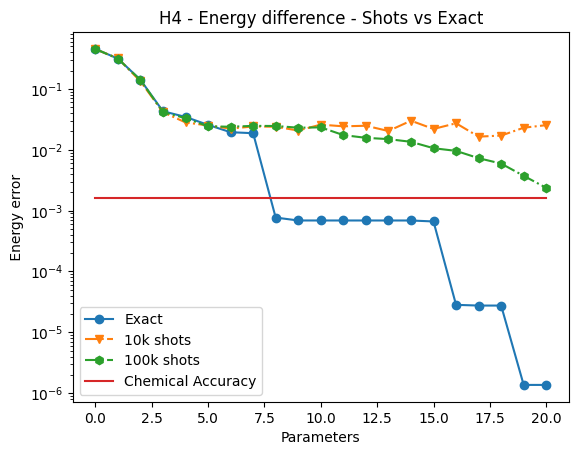

In [7]:
import numpy as np
params = []
for k in range(21):
    params.append(k)

print(params)

E_exact = np.array([-1.4300836708403402, -1.5694603835520677, -1.7436334426149698, -1.8421101514362364, -1.8504359363275726, -1.8594600250247684, 
                    -1.8656767410817476, -1.8663879748309666, -1.884356033007819, -1.8844361654314306, -1.8844361671921899, -1.8844364522332315, 
                    -1.8844364556758229, -1.8844365760316029, -1.884436576484849, -1.8844612572187276, -1.885096631853509, -1.885097395511084, 
                    -1.8850973962695554, -1.885123539547584, -1.885123539730992])



E_100k_mean = np.array([-1.43104792, -1.5708801,  -1.74465923, -1.84339265, -1.85203361, -1.86081376, 
                        -1.86121146, -1.86039891, -1.86050403, -1.86206095, -1.86176063, -1.86767676,
                        -1.8693998,  -1.87014785, -1.87160031, -1.87450793, -1.87552824, -1.8778455,
                        -1.87919167, -1.88139317, -1.88275661])

E_100k_variance = np.array([2.63717812e-07, 8.64238134e-08, 1.77790212e-08, 1.17315186e-06,
                             1.56003491e-07, 4.12775562e-07, 2.38226042e-07, 1.43415218e-07,
                             1.23275457e-06, 5.27275404e-06, 2.75752891e-06, 6.64021786e-05,
                             1.11316720e-04, 1.21573202e-04, 1.11473173e-04, 1.25515023e-04,
                             8.33640480e-05, 4.60585548e-05, 2.69959673e-05, 2.13111222e-05,
                             1.93871307e-05])

E_10k = np.array([-1.4351673889352257, -1.5651991504418161, -1.751469123615361, -1.8436952594174199, -1.8569282898247246, -1.8600672216690162,
                   -1.8628077792693236, -1.8609601988065476, -1.8611885481633914, -1.8643987945828824, -1.859208081363875,-1.8608238017901975,
                   -1.8602877158680589, -1.8647583024593826, -1.8550588122073244, -1.8631195449319817, -1.8578492010166685, -1.8686697660828904,
                   -1.868002835086847,-1.8620610309226926,  -1.859707949605153]) #Powell - 10k shots - 0th iteration

#FCI =  -1.885124904189219
#print('FCI energies are', FCI)
FCI = np.full(shape=21, fill_value= -1.885124904189219)
#print(FCI)
Error_100k = abs(E_100k_mean - FCI)
print(Error_100k)
Error_10k = abs(E_10k - FCI)
Error_exact = (E_exact - FCI)

chem_accuracy = np.full(fill_value=1.59e-3, shape=21)


import matplotlib.pyplot as plt
plt.plot(params, Error_exact, '-o', label = 'Exact')
plt.plot(params, Error_10k, '-.v', label = '10k shots')
plt.plot(params, Error_100k, '-.h', label = '100k shots')
plt.plot(params, chem_accuracy, '-', label = 'Chemical Accuracy')
plt.legend()
plt.yscale('log')
#plt.yscale('symlog')
#plt.ylim(-1.90, -1.8)
plt.xlabel('Parameters')
plt.title('H4 - Energy difference - Shots vs Exact')
plt.ylabel(' Energy error ')
plt.show()

## Calculating mean and variance for 100k shots

In [43]:
import numpy as np

E_100k = np.array([-1.431464387461462, -1.5706137840445968, -1.7445154292149, -1.844173238851841, -1.8524862425248212, -1.8610473845425686,
                    -1.8605410002761278, -1.8598552535070012, -1.8588853857612926, -1.8609569752901267,  -1.861604086709718, -1.8831889197982379,
                    -1.8861726774026286,-1.8840488019855615, -1.8849791250167156,  -1.88632288156302, -1.8828073690834548, -1.883695972101264,
                      -1.884379016297748, -1.8854498416713266, -1.885303132220318]) #Powell - 100k shots - 1st iteration

E_100k1 = np.array([-1.4314606079236005,-1.5713046274227158,  -1.744744624339305, -1.8440418744811005,-1.851417399353439, -1.8613720708915669,
                    -1.8617680552763938, -1.8607818655703572,-1.8599335440388962, -1.8614656614212948,  -1.8595372612740584, -1.8608650142483987,
                    -1.8599291289619784, -1.859387197802784, -1.8607535366278023, -1.8586276461372815, -1.8642916275997419, -1.8732667587433893,
                    -1.8757460322487636,  -1.8795162160777772, -1.8828801422808312]) #Powell - 100k shots - 0th iteration

E_100k2 = np.array([-1.4313714384136569, -1.5711599653185464, -1.7448177461438643,-1.8415299757922103, -1.8524265691167463, -1.859556896655395,
                    -1.860876979265782, -1.8608721532709025, -1.8622637592650026,  -1.8640457714077514, -1.8621194157024508, -1.8636416254952275,
                    -1.8618357163835415, -1.8642006114239906, -1.8649905718527253, -1.882249520476496, -1.8842096633530534, -1.885065653965093,
                    -1.8815440958924905, -1.885353101925897, -1.886320018113996]) #Powell - 100k shots - 2nd iteration

E_100k3 = np.array([-1.4301507671894955, -1.5707188490439874, -1.7444851059209008, -1.844406492942702,-1.852004677332494, -1.8611162513092265,
                    -1.8617668625758483,-1.8602747414659213,  -1.860840108708431,-1.8651438724704288, -1.8645944575303506,-1.8683289949226005,
                    -1.8775404418202968,  -1.8829427344054044,-1.883854792892886,-1.8818651644292685, -1.881856715636931,  -1.8801917076861874,
                     -1.8835588158016838, -1.8834246747274124,  -1.885039420674735]) #Powell - 100k shots - 3rd iteration

E_100k4 = np.array([-1.430792410190207, -1.5706032518842084, -1.7447332413775998, -1.8428116894336073,-1.8518331811441604, -1.8609761788250707,
                    -1.8611043792735145, -1.8602105440820966, -1.8605973758377032, -1.8586924615269302, -1.8609479402724485, -1.862359223905536,
                    -1.8615210207218613, -1.8601598975122056, -1.8634235324160766, -1.8634744582781184, -1.8644758037877995, -1.8670073929166127,
                    -1.8707304061743706, -1.8732220013185512, -1.8742403598933248]) #Powell - 100k shots - 4th iteration


data_sets = np.array([E_100k, E_100k1, E_100k2, E_100k3, E_100k4])  # 3 datasets, each with 21 values

# Calculate the mean and variance for each of the 21 values across all datasets
means = np.mean(data_sets, axis=0)  # mean for each of the 21 values
variances = np.var(data_sets, axis=0)  # variance for each of the 21 values
SD = np.std(data_sets, axis=0)  # standard deviation for each of the 21 values
# Print results
print("Means of the 21 values across datasets:")
print(means)

print("Variances of the 21 values across datasets:")
print(variances)



Means of the 21 values across datasets:
[-1.43104792 -1.5708801  -1.74465923 -1.84339265 -1.85203361 -1.86081376
 -1.86121146 -1.86039891 -1.86050403 -1.86206095 -1.86176063 -1.86767676
 -1.8693998  -1.87014785 -1.87160031 -1.87450793 -1.87552824 -1.8778455
 -1.87919167 -1.88139317 -1.88275661]
Variances of the 21 values across datasets:
[2.63717812e-07 8.64238134e-08 1.77790212e-08 1.17315186e-06
 1.56003491e-07 4.12775562e-07 2.38226042e-07 1.43415218e-07
 1.23275457e-06 5.27275404e-06 2.75752891e-06 6.64021786e-05
 1.11316720e-04 1.21573202e-04 1.11473173e-04 1.25515023e-04
 8.33640480e-05 4.60585548e-05 2.69959673e-05 2.13111222e-05
 1.93871307e-05]


## Calculating mean and variance for 10k shots

In [17]:
E_10k = np.array([-1.4351673889352257, -1.5651991504418161, -1.751469123615361, -1.8436952594174199, -1.8569282898247246, -1.8600672216690162,
                   -1.8628077792693236, -1.8609601988065476, -1.8611885481633914, -1.8643987945828824, -1.859208081363875,-1.8608238017901975,
                   -1.8602877158680589, -1.8647583024593826, -1.8550588122073244, -1.8631195449319817, -1.8578492010166685, -1.8686697660828904,
                   -1.868002835086847,-1.8620610309226926,  -1.859707949605153]) #Powell - 10k shots - 0th iteration

E_10k1 = np.array([-1.4337604591612352, -1.5753674383809777, -1.7484692166786466, -1.8371679102023841, -1.853248324766829, -1.8654690149596171,
                   -1.8522499429851975,-1.8626829995276881, -1.8611447359979683, -1.859435592028428, -1.8575005839630203,-1.8643337202271781,
                    -1.8720793827295314, -1.8777442877293082,  -1.8730835161218478, -1.8813791564333107,-1.8769297829298928,-1.8842080582892864,
                    -1.8815505501105734, -1.882984111477743,  -1.8830447698994495]) #Powell - 10k shots - 1st iteration

E_10k2 = np.array([-1.4350475595803476,-1.5726877722180044, -1.7462372475740284, -1.8463923080708662, -1.8559963636899637, -1.8592036423932659,
                   -1.8626347062716175, -1.8611278279496357, -1.8658340064115435,  -1.8627954724028486, -1.864781806280686, -1.863956825805783,
                    -1.8608285906626638, -1.8626639194125607,-1.8667777745262777, -1.8653327352763, -1.8640068001081962, -1.8699635119073392,
                    -1.8737681547417946,  -1.8705288882156794, -1.8595677364700758   ]) #Powell - 10k shots - 2nd iteration

E_10k3 = np.array([-1.4347519210111082,-1.5783399221673284, -1.7456859054137577, -1.8480605862056738, -1.8543437375990366,  -1.8649184015832772,
                  -1.8625285071331903, -1.8629282353089973,  -1.864691592270755, -1.8619372962633258, -1.8564475239365446,  -1.8564066432782729,
                  -1.8658574327286694, -1.8612700355380107,-1.864770254153661,-1.869648336274999, -1.861241122205256, -1.8758763506499747,
                    -1.8691463761784084,  -1.8737985434846571, -1.8798223286857787 ]) #Powell - 10k shots - 3rd iteration

E_10k4 = np.array([-1.4359058556482822,-1.5758491033294224,-1.746819925197857,-1.844347846338895,-1.8503784155142844, -1.8642132915475866,
                    -1.859382536093539, -1.8607567458002214, -1.8607141102743414,-1.8631703038345413,-1.8662042514664463,-1.8572349160837576,
                    -1.860643737799147, -1.8557535258345452, -1.8531900116371527, -1.8469556021675353, -1.8586627053765457, -1.85929293986438,
                    -1.852846155133066, -1.8577981691457104,  -1.859255100571149   ]) #Powell - 10k shots - 4th iteration

data_sets = np.array([E_10k, E_10k1, E_10k2, E_10k3, E_10k4]) 
 # 3 datasets, each with 21 values
#data_sets = np.array([2,3,4,5,6])  
# Calculate the mean and variance for each of the 21 values across all datasets
means = np.mean(data_sets, axis=0)  # mean for each of the 21 values
variances = np.var(data_sets, axis=0)  # variance for each of the 21 values

# Print results
print("Means of the 21 values across datasets:")
print(means)

print("Variances of the 21 values across datasets:")
print(variances)

Means of the 21 values across datasets:
[-1.43492664 -1.57348868 -1.74773628 -1.84393278 -1.85417903 -1.86277431
 -1.85992069 -1.8616912  -1.8627146  -1.86234749 -1.86082845 -1.86055118
 -1.86393937 -1.86443801 -1.86257607 -1.86528708 -1.86373792 -1.87160213
 -1.86906281 -1.86943415 -1.86827958]
Variances of the 21 values across datasets:
[4.84389871e-07 2.03987271e-05 4.35243158e-06 1.38160444e-05
 5.23982852e-06 6.80144516e-06 1.63263697e-05 8.47775624e-07
 4.48689223e-06 2.74659401e-06 1.54842135e-05 1.08310295e-05
 2.07622979e-05 5.31526678e-05 5.54964891e-05 1.23743770e-04
 4.81532716e-05 6.79956759e-05 8.84388695e-05 7.87213547e-05
 1.16411235e-04]


## Plots with 10k and 100k mean and variance

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]


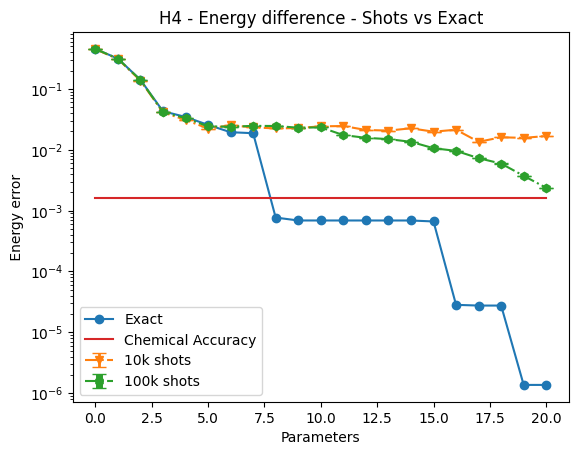

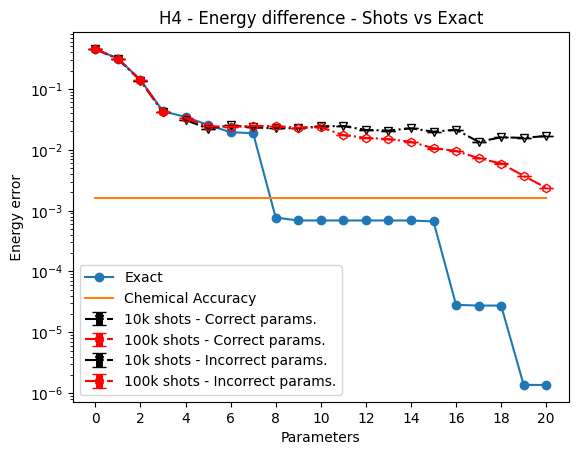

In [199]:
import numpy as np
params = []
for k in range(21):
    params.append(k)

print(params)

E_exact = np.array([-1.4300836708403402, -1.5694603835520677, -1.7436334426149698, -1.8421101514362364, -1.8504359363275726, -1.8594600250247684, 
                    -1.8656767410817476, -1.8663879748309666, -1.884356033007819, -1.8844361654314306, -1.8844361671921899, -1.8844364522332315, 
                    -1.8844364556758229, -1.8844365760316029, -1.884436576484849, -1.8844612572187276, -1.885096631853509, -1.885097395511084, 
                    -1.8850973962695554, -1.885123539547584, -1.885123539730992])



E_100k_mean = np.array([-1.43104792, -1.5708801,  -1.74465923, -1.84339265, -1.85203361, -1.86081376, 
                        -1.86121146, -1.86039891, -1.86050403, -1.86206095, -1.86176063, -1.86767676,
                        -1.8693998,  -1.87014785, -1.87160031, -1.87450793, -1.87552824, -1.8778455,
                        -1.87919167, -1.88139317, -1.88275661])

E_100k_variance = np.array([2.63717812e-07, 8.64238134e-08, 1.77790212e-08, 1.17315186e-06,
                             1.56003491e-07, 4.12775562e-07, 2.38226042e-07, 1.43415218e-07,
                             1.23275457e-06, 5.27275404e-06, 2.75752891e-06, 6.64021786e-05,
                             1.11316720e-04, 1.21573202e-04, 1.11473173e-04, 1.25515023e-04,
                             8.33640480e-05, 4.60585548e-05, 2.69959673e-05, 2.13111222e-05, 1.93871307e-05])


E_10k_mean  =  np.array([-1.43492664, -1.57348868, -1.74773628, -1.84393278, -1.85417903, -1.86277431,
                          -1.85992069 ,-1.8616912 , -1.8627146,  -1.86234749, -1.86082845, -1.86055118,
                          -1.86393937 ,-1.86443801, -1.86257607, -1.86528708, -1.86373792, -1.87160213,
                          -1.86906281 ,-1.86943415, -1.86827958])

E_10k_variance = np.array([4.84389871e-07, 2.03987271e-05, 4.35243158e-06, 1.38160444e-05,
                           5.23982852e-06, 6.80144516e-06 ,1.63263697e-05, 8.47775624e-07,
                           4.48689223e-06, 2.74659401e-06 ,1.54842135e-05, 1.08310295e-05,
                           2.07622979e-05, 5.31526678e-05 ,5.54964891e-05, 1.23743770e-04,
                           4.81532716e-05, 6.79956759e-05, 8.84388695e-05, 7.87213547e-05, 1.16411235e-04])





FCI = np.full(shape=21, fill_value= -1.885124904189219)

Error_100k = abs(E_100k_mean - FCI)

Error_10k = abs(E_10k_mean - FCI)

Error_exact = abs(E_exact - FCI)

chem_accuracy = np.full(fill_value=1.59e-3, shape=21)


import matplotlib.pyplot as plt
plt.plot(params, Error_exact, '-o', label = 'Exact')

plt.errorbar(params, Error_10k, yerr=E_10k_variance, fmt='-.v', elinewidth=2, capsize=5, label = '10k shots')
plt.errorbar(params, Error_100k, yerr=E_100k_variance, fmt='-.h', elinewidth=5, capsize=5, label = '100k shots')
plt.plot(params, chem_accuracy, '-', label = 'Chemical Accuracy')
plt.legend(loc = 'lower left')
plt.yscale('log')
#plt.xlim(12, 20)
#plt.ylim(1e-3, 1e-1)
plt.xlabel('Parameters')
plt.title('H4 - Energy difference - Shots vs Exact')
plt.ylabel(' Energy error ')
plt.show()


plt.plot(params, Error_exact, '-o', label = 'Exact')
plt.errorbar(params[:4], Error_10k[:4], yerr=E_10k_variance[:4], fmt='-.v', color='k',elinewidth=5, capsize=5, label='10k shots - Correct params.')
plt.errorbar(params[:4], Error_100k[:4], yerr=E_100k_variance[:4], fmt='-.h', color= 'r',elinewidth=5, capsize=5, label='100k shots - Correct params.')

plt.plot(params, chem_accuracy, '-', label = 'Chemical Accuracy')
plt.errorbar(params[4:], Error_10k[4:], yerr=E_10k_variance[4:], fmt='-.v', elinewidth=5,  color= 'k',capsize=5,markerfacecolor='none', label='10k shots - Incorrect params.')
plt.errorbar(params[4:], Error_100k[4:], yerr=E_100k_variance[4:], fmt='-.h', elinewidth=5, color = 'r',capsize=5,markerfacecolor='none', label='100k shots - Incorrect params.')
plt.xticks(np.arange(0, 22, 2)) 
plt.legend(loc = 'lower left')
plt.yscale('log')
plt.xlabel('Parameters')
plt.title('H4 - Energy difference - Shots vs Exact')
plt.ylabel(' Energy error ')
plt.show()

## Mean + 5 plots

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]


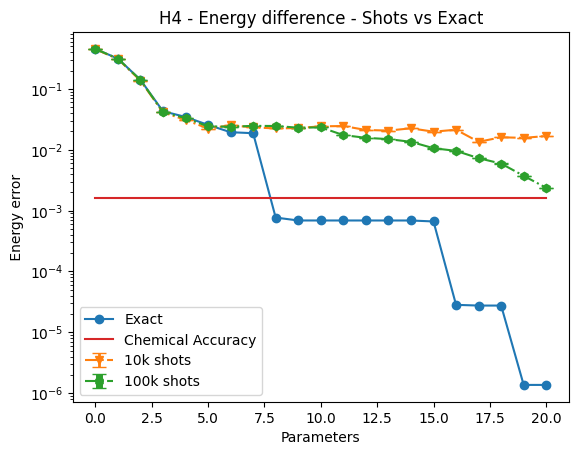

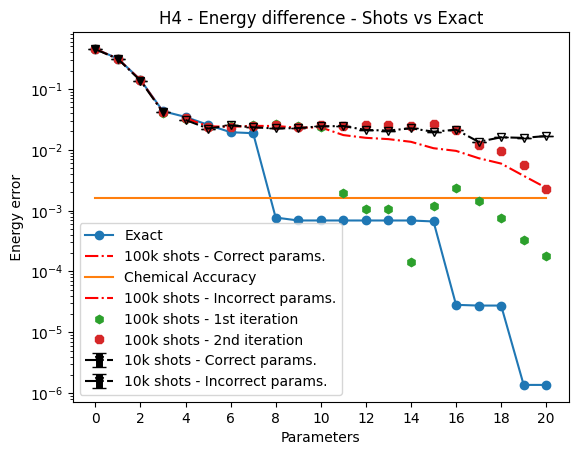

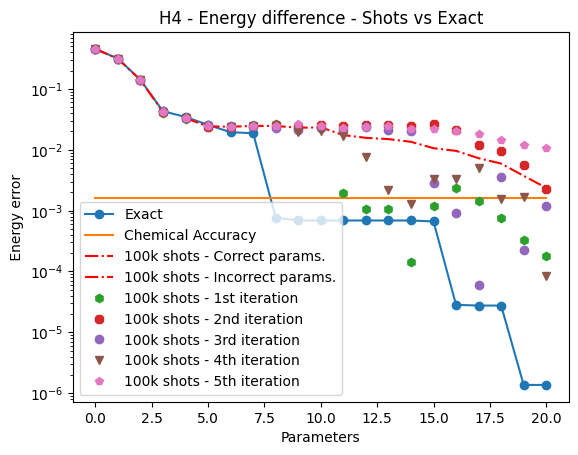

In [216]:
import numpy as np
params = []
for k in range(21):
    params.append(k)

print(params)

E_exact = np.array([-1.4300836708403402, -1.5694603835520677, -1.7436334426149698, -1.8421101514362364, -1.8504359363275726, -1.8594600250247684, 
                    -1.8656767410817476, -1.8663879748309666, -1.884356033007819, -1.8844361654314306, -1.8844361671921899, -1.8844364522332315, 
                    -1.8844364556758229, -1.8844365760316029, -1.884436576484849, -1.8844612572187276, -1.885096631853509, -1.885097395511084, 
                    -1.8850973962695554, -1.885123539547584, -1.885123539730992])



E_100k_mean = np.array([-1.43104792, -1.5708801,  -1.74465923, -1.84339265, -1.85203361, -1.86081376, 
                        -1.86121146, -1.86039891, -1.86050403, -1.86206095, -1.86176063, -1.86767676,
                        -1.8693998,  -1.87014785, -1.87160031, -1.87450793, -1.87552824, -1.8778455,
                        -1.87919167, -1.88139317, -1.88275661])

E_100k_variance = np.array([2.63717812e-07, 8.64238134e-08, 1.77790212e-08, 1.17315186e-06,
                             1.56003491e-07, 4.12775562e-07, 2.38226042e-07, 1.43415218e-07,
                             1.23275457e-06, 5.27275404e-06, 2.75752891e-06, 6.64021786e-05,
                             1.11316720e-04, 1.21573202e-04, 1.11473173e-04, 1.25515023e-04,
                             8.33640480e-05, 4.60585548e-05, 2.69959673e-05, 2.13111222e-05, 1.93871307e-05])


E_10k_mean  =  np.array([-1.43492664, -1.57348868, -1.74773628, -1.84393278, -1.85417903, -1.86277431,
                          -1.85992069 ,-1.8616912 , -1.8627146,  -1.86234749, -1.86082845, -1.86055118,
                          -1.86393937 ,-1.86443801, -1.86257607, -1.86528708, -1.86373792, -1.87160213,
                          -1.86906281 ,-1.86943415, -1.86827958])

E_10k_variance = np.array([4.84389871e-07, 2.03987271e-05, 4.35243158e-06, 1.38160444e-05,
                           5.23982852e-06, 6.80144516e-06 ,1.63263697e-05, 8.47775624e-07,
                           4.48689223e-06, 2.74659401e-06 ,1.54842135e-05, 1.08310295e-05,
                           2.07622979e-05, 5.31526678e-05 ,5.54964891e-05, 1.23743770e-04,
                           4.81532716e-05, 6.79956759e-05, 8.84388695e-05, 7.87213547e-05, 1.16411235e-04])

E_100k = np.array([-1.431464387461462, -1.5706137840445968, -1.7445154292149, -1.844173238851841, -1.8524862425248212, -1.8610473845425686,
                    -1.8605410002761278, -1.8598552535070012, -1.8588853857612926, -1.8609569752901267,  -1.861604086709718, -1.8831889197982379,
                    -1.8861726774026286,-1.8840488019855615, -1.8849791250167156,  -1.88632288156302, -1.8828073690834548, -1.883695972101264,
                      -1.884379016297748, -1.8854498416713266, -1.885303132220318]) #Powell - 100k shots - 1st iteration

E_100k1 = np.array([-1.4314606079236005,-1.5713046274227158,  -1.744744624339305, -1.8440418744811005,-1.851417399353439, -1.8613720708915669,
                    -1.8617680552763938, -1.8607818655703572,-1.8599335440388962, -1.8614656614212948,  -1.8595372612740584, -1.8608650142483987,
                    -1.8599291289619784, -1.859387197802784, -1.8607535366278023, -1.8586276461372815, -1.8642916275997419, -1.8732667587433893,
                    -1.8757460322487636,  -1.8795162160777772, -1.8828801422808312]) #Powell - 100k shots - 0th iteration

E_100k2 = np.array([-1.4313714384136569, -1.5711599653185464, -1.7448177461438643,-1.8415299757922103, -1.8524265691167463, -1.859556896655395,
                    -1.860876979265782, -1.8608721532709025, -1.8622637592650026,  -1.8640457714077514, -1.8621194157024508, -1.8636416254952275,
                    -1.8618357163835415, -1.8642006114239906, -1.8649905718527253, -1.882249520476496, -1.8842096633530534, -1.885065653965093,
                    -1.8815440958924905, -1.885353101925897, -1.886320018113996]) #Powell - 100k shots - 2nd iteration

E_100k3 = np.array([-1.4301507671894955, -1.5707188490439874, -1.7444851059209008, -1.844406492942702,-1.852004677332494, -1.8611162513092265,
                    -1.8617668625758483,-1.8602747414659213,  -1.860840108708431,-1.8651438724704288, -1.8645944575303506,-1.8683289949226005,
                    -1.8775404418202968,  -1.8829427344054044,-1.883854792892886,-1.8818651644292685, -1.881856715636931,  -1.8801917076861874,
                     -1.8835588158016838, -1.8834246747274124,  -1.885039420674735]) #Powell - 100k shots - 3rd iteration

E_100k4 = np.array([-1.430792410190207, -1.5706032518842084, -1.7447332413775998, -1.8428116894336073,-1.8518331811441604, -1.8609761788250707,
                    -1.8611043792735145, -1.8602105440820966, -1.8605973758377032, -1.8586924615269302, -1.8609479402724485, -1.862359223905536,
                    -1.8615210207218613, -1.8601598975122056, -1.8634235324160766, -1.8634744582781184, -1.8644758037877995, -1.8670073929166127,
                    -1.8707304061743706, -1.8732220013185512, -1.8742403598933248]) #Powell - 100k shots - 4th iteration





FCI = np.full(shape=21, fill_value= -1.885124904189219)

Error_100k = abs(E_100k_mean - FCI)

Error_10k = abs(E_10k_mean - FCI)

Error_exact = abs(E_exact - FCI)

chem_accuracy = np.full(fill_value=1.59e-3, shape=21)

Error_0th = abs(E_100k - FCI)
Error_1st = abs(E_100k1 - FCI)
Error_2nd = abs(E_100k2 - FCI)
Error_3rd = abs(E_100k3 - FCI)
Error_4th = abs(E_100k4 - FCI)


import matplotlib.pyplot as plt
plt.plot(params, Error_exact, '-o', label = 'Exact')

plt.errorbar(params, Error_10k, yerr=E_10k_variance, fmt='-.v', elinewidth=2, capsize=5, label = '10k shots')
plt.errorbar(params, Error_100k, yerr=E_100k_variance, fmt='-.h', elinewidth=5, capsize=5, label = '100k shots')
plt.plot(params, chem_accuracy, '-', label = 'Chemical Accuracy')
plt.legend(loc = 'lower left')
plt.yscale('log')
#plt.xlim(12, 20)
#plt.ylim(1e-3, 1e-1)
plt.xlabel('Parameters')
plt.title('H4 - Energy difference - Shots vs Exact')
plt.ylabel(' Energy error ')
plt.show()


plt.plot(params, Error_exact, '-o', label = 'Exact')
plt.errorbar(params[:4], Error_10k[:4], yerr=E_10k_variance[:4], fmt='-.v', color='k',elinewidth=5, capsize=5, label='10k shots - Correct params.')
plt.plot(params[:4], Error_100k[:4],  '-.r', label='100k shots - Correct params.')

plt.plot(params, chem_accuracy, '-', label = 'Chemical Accuracy')
plt.errorbar(params[4:], Error_10k[4:], yerr=E_10k_variance[4:], fmt='-.v', elinewidth=5,  color= 'k',capsize=5,markerfacecolor='none', label='10k shots - Incorrect params.')
plt.plot(params[4:], Error_100k[4:], '-.r',markerfacecolor='none', label='100k shots - Incorrect params.')

plt.plot(params, Error_0th, 'h', label = '100k shots - 1st iteration')
plt.plot(params, Error_1st, '8', label = '100k shots - 2nd iteration')
plt.xticks(np.arange(0, 22, 2)) 
plt.legend(loc = 'lower left')
plt.yscale('log')
plt.xlabel('Parameters')
plt.title('H4 - Energy difference - Shots vs Exact')
plt.ylabel(' Energy error ')
plt.show()

plt.plot(params, Error_exact, '-o', label = 'Exact')
plt.plot(params, chem_accuracy, '-', label = 'Chemical Accuracy')
plt.plot(params[:4], Error_100k[:4],  '-.r', label='100k shots - Correct params.')
plt.plot(params[4:], Error_100k[4:], '-.r',markerfacecolor='none', label='100k shots - Incorrect params.')
plt.plot(params, Error_0th, 'h', label = '100k shots - 1st iteration')
plt.plot(params, Error_1st, '8', label = '100k shots - 2nd iteration')
plt.plot(params, Error_2nd, 'o', label = '100k shots - 3rd iteration')
plt.plot(params, Error_3rd, 'v', label = '100k shots - 4th iteration')
plt.plot(params, Error_4th, 'p', label = '100k shots - 5th iteration')
plt.yscale('log')
plt.legend()
plt.xlabel('Parameters')
plt.title('H4 - Energy difference - Shots vs Exact')
plt.ylabel(' Energy error ')
plt.show()



## Trying to animate the figure - Gradients 

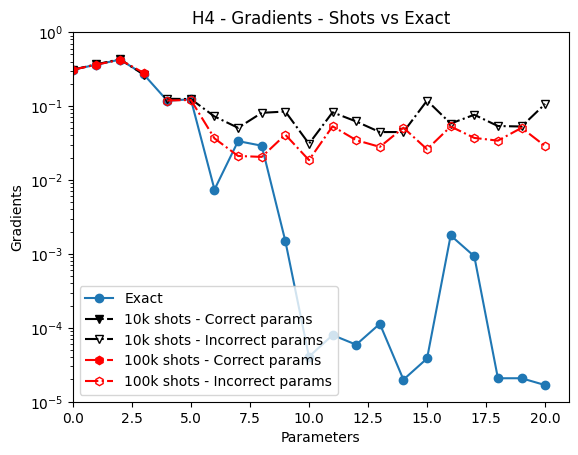

In [205]:
import numpy as np
params = np.linspace(0, 20, 21)


G_Exact = (0.3100451588582116 , 0.36333417728273754, 0.4247574417703076, 0.2689421354231678, 0.11800197933700611, 0.12345368822802208,
              0.007420281812857612, 0.03354563739855884 , 0.029061752158627868, 0.0014907673809587962, 4.058027986704677e-05, 7.976896690634755e-05,
               5.913441683514514e-05, 0.00011328401551519846, 1.989246929409716e-05, 3.843530082175278e-05,  0.0017755760879906296, 0.0009282356568736209,
                 2.0769533991756538e-05, 2.0776790979757515e-05,1.678514206528755e-05)

G_100k = np.array([0.31012233368556263, 0.36278153764485294, 0.4224954854006534 , 0.28153706300448905, 0.11874528439791214, 0.12091574177009903,
                  0.036496747329089814, 0.021113196148753528, 0.020510792058557496, 0.04093571514178557, 0.01856540574468836, 0.053177591263377365,
                  0.03457620605522451, 0.02801950135618726, 0.050944905880169374, 0.02601220513310512 , 0.05287811195945368, 0.03704241195091213,
                  0.03403801969187872, 0.0506735825987322, 0.028745987022101658])  #Powell - 100k shots - 0th iteration

G_10k = np.array([0.3099162431306309, 0.36686751091589886 , 0.4303872599459001, 0.26664492219594843,0.12542908670332384, 0.1243034054423584,
                  0.07227267823768933, 0.050733283680761736, 0.08093960390932564, 0.08428620993570457, 0.030903952492093528, 0.0822684282601312,
                  0.061834972747899175, 0.04443504550103138, 0.04451098756987766, 0.11852872186034469, 0.05802126112805322, 0.07620382263558934,
                  0.05366141510645424, 0.052880135251468355,  0.106829094059067]) #Powell - 10k shots - 0th iteration

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import PillowWriter




fig = plt.figure()

l, = plt.plot([], [], '-o')
l1, = plt.plot([], [], '-.v', color='k')
l11, = plt.plot([], [], '-.v',markerfacecolor='none', color='k')
l2, = plt.plot([], [], '-.h', color='r')
l21, = plt.plot([], [], '-.h', color='r', markerfacecolor='none')

plt.xlim(0, 21)
plt.ylim(1e-5, 1)
plt.yscale('log')

metadata = dict(title='Gradient', artist='Matplotlib')
writer = PillowWriter(fps=15, metadata=metadata)


xlist = []
ylist = []

xlist10k = []
ylist10k = []

xlist10k1 = []
ylist10k1 = []

xlist100k = []  
ylist100k = []

xlist100k1 = []  
ylist100k1 = []



with writer.saving(fig, "ash1.gif", 100):
    for i in range(0, 21):
        xlist.append(params[i])
        ylist.append(G_Exact[i])
        l.set_data(xlist,ylist)
        l.set_label('Exact')
        plt.legend()
        plt.xlabel('Parameters')
        plt.title('H4 - Gradients - Shots vs Exact')
        plt.ylabel('Gradients')
        writer.grab_frame()
        writer.grab_frame()
        writer.grab_frame()


    for ii in range(30):
        writer.grab_frame()
    
    #10k shots - Correct params
    for i in range(0, 4):
        xlist10k.append(params[:4][i])
        ylist10k.append(G_10k[:4][i])
        l1.set_data(xlist10k,ylist10k)
        l1.set_label('10k shots - Correct params')
        plt.legend()
        writer.grab_frame()

    for ii in range(30):
        writer.grab_frame()
    #10k shots - Incorrect params
    for i in range(0,17):
        xlist10k1.append(params[4:][i])
        ylist10k1.append(G_10k[4:][i])
        l11.set_data(xlist10k1,ylist10k1)
        l11.set_label('10k shots - Incorrect params')
        plt.legend()

        writer.grab_frame()
        writer.grab_frame()
        writer.grab_frame()
        writer.grab_frame()

    for ii in range(30):
        writer.grab_frame()

    #100k shots - Correct params
    for i in range(0, 4):
        xlist100k.append(params[:4][i])
        ylist100k.append(G_100k[:4][i])
        l2.set_data(xlist100k,ylist100k)
        l2.set_label('100k shots - Correct params')
        plt.legend()

        writer.grab_frame()

    for ii in range(30):
        writer.grab_frame()
    #100k shots - Incorrect params
    for i in range(0,17):
        xlist100k1.append(params[4:][i])
        ylist100k1.append(G_100k[4:][i])
        l21.set_data(xlist100k1,ylist100k1)
        l21.set_label('100k shots - Incorrect params')
        plt.legend()

        writer.grab_frame()
        writer.grab_frame()
        writer.grab_frame()
        writer.grab_frame()


    for ii in range(1000):
        writer.grab_frame()

plt.show()


## Animate the energy 

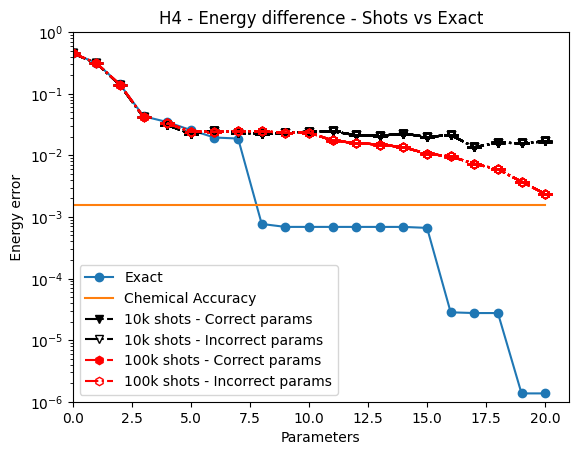

In [204]:
import numpy as np
params = np.linspace(0, 20, 21)

E_exact = (-1.4300836708403402, -1.5694603835520677, -1.7436334426149698, -1.8421101514362364, -1.8504359363275726, -1.8594600250247684, 
                    -1.8656767410817476, -1.8663879748309666, -1.884356033007819, -1.8844361654314306, -1.8844361671921899, -1.8844364522332315, 
                    -1.8844364556758229, -1.8844365760316029, -1.884436576484849, -1.8844612572187276, -1.885096631853509, -1.885097395511084, 
                    -1.8850973962695554, -1.885123539547584, -1.885123539730992)



E_100k_mean = np.array([-1.43104792, -1.5708801,  -1.74465923, -1.84339265, -1.85203361, -1.86081376, 
                        -1.86121146, -1.86039891, -1.86050403, -1.86206095, -1.86176063, -1.86767676,
                        -1.8693998,  -1.87014785, -1.87160031, -1.87450793, -1.87552824, -1.8778455,
                        -1.87919167, -1.88139317, -1.88275661])

E_100k_variance = np.array([2.63717812e-07, 8.64238134e-08, 1.77790212e-08, 1.17315186e-06,
                             1.56003491e-07, 4.12775562e-07, 2.38226042e-07, 1.43415218e-07,
                             1.23275457e-06, 5.27275404e-06, 2.75752891e-06, 6.64021786e-05,
                             1.11316720e-04, 1.21573202e-04, 1.11473173e-04, 1.25515023e-04,
                             8.33640480e-05, 4.60585548e-05, 2.69959673e-05, 2.13111222e-05, 1.93871307e-05])


E_10k_mean  =  np.array([-1.43492664, -1.57348868, -1.74773628, -1.84393278, -1.85417903, -1.86277431,
                          -1.85992069 ,-1.8616912 , -1.8627146,  -1.86234749, -1.86082845, -1.86055118,
                          -1.86393937 ,-1.86443801, -1.86257607, -1.86528708, -1.86373792, -1.87160213,
                          -1.86906281 ,-1.86943415, -1.86827958])

E_10k_variance = np.array([4.84389871e-07, 2.03987271e-05, 4.35243158e-06, 1.38160444e-05,
                           5.23982852e-06, 6.80144516e-06 ,1.63263697e-05, 8.47775624e-07,
                           4.48689223e-06, 2.74659401e-06 ,1.54842135e-05, 1.08310295e-05,
                           2.07622979e-05, 5.31526678e-05 ,5.54964891e-05, 1.23743770e-04,
                           4.81532716e-05, 6.79956759e-05, 8.84388695e-05, 7.87213547e-05, 1.16411235e-04])


import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import PillowWriter

FCI = np.full(shape=21, fill_value= -1.885124904189219)

Error_100k = abs(E_100k_mean - FCI)

Error_10k = abs(E_10k_mean - FCI)

Error_exact = abs(E_exact - FCI)

chem_accuracy = np.full(fill_value=1.59e-3, shape=21)


fig = plt.figure()

l, = plt.plot([], [], '-o')
l5, = plt.plot([], [], '-')
l1, = plt.plot([], [], '-.v', color='k')
l11, = plt.plot([], [], '-.v',markerfacecolor='none', color='k')
l2, = plt.plot([], [], '-.h', color='r')
l21, = plt.plot([], [], '-.h', color='r', markerfacecolor='none')


plt.xlim(0, 21)
plt.ylim(1e-6, 1)
plt.yscale('log')
plt.xlabel('Parameters')
plt.title('H4 - Energy difference - Shots vs Exact')
plt.ylabel(' Energy error ')

metadata = dict(title='Gradient', artist='Matplotlib')
writer = PillowWriter(fps=15, metadata=metadata)


xlist = []
ylist = []

xlist10k = []
ylist10k = []

xlist10k1 = []
ylist10k1 = []

xlist100k = []  
ylist100k = []

xlist100k1 = []  
ylist100k1 = []

xlistchem = []
ylistchem = []


with writer.saving(fig, "ash2.gif", 100):
    for i in range(0, 21):
        xlist.append(params[i])
        ylist.append(Error_exact[i])
        #print(ylist)
        l.set_data(xlist,ylist)
        l.set_label('Exact')
        plt.legend()
        plt.xlabel('Parameters')
        plt.title('H4 - Energy difference - Shots vs Exact')
        plt.ylabel(' Energy error ')
        writer.grab_frame()
        writer.grab_frame()
        writer.grab_frame()

    for ii in range(5):
        writer.grab_frame()
    for i in range(21):
        xlistchem.append(params[i])
        ylistchem.append(chem_accuracy[i])
        l5.set_data(xlistchem, ylistchem)
        l5.set_label('Chemical Accuracy')
        plt.legend()

        writer.grab_frame()

    for ii in range(30):
        writer.grab_frame()
    
    #10k shots - Correct params
    for i in range(0, 4):
        xlist10k.append(params[:4][i])
        ylist10k.append(Error_10k[:4][i])
        plt.errorbar(params[:4], Error_10k[:4], yerr=E_10k_variance[:4], fmt='-.v', color='k',elinewidth=5, capsize=5)
        l1.set_data(xlist10k,ylist10k)
        l1.set_label('10k shots - Correct params')
        plt.legend()
        writer.grab_frame()
        writer.grab_frame()
    for ii in range(30):
        writer.grab_frame()
    #10k shots - Incorrect params
    for i in range(0,17):
        xlist10k1.append(params[4:][i])
        ylist10k1.append(Error_10k[4:][i])
        plt.errorbar(params[4:], Error_10k[4:], yerr=E_10k_variance[4:], fmt='-.v', elinewidth=5,  color= 'k',capsize=5,markerfacecolor='none')
        l11.set_data(xlist10k1,ylist10k1)
        l11.set_label('10k shots - Incorrect params')
        plt.legend()
        writer.grab_frame()
        writer.grab_frame()
    for ii in range(30):
        writer.grab_frame()

    #100k shots - Correct params
    for i in range(0, 4):
        xlist100k.append(params[:4][i])
        ylist100k.append(Error_100k[:4][i])
        plt.errorbar(params[:4], Error_100k[:4], yerr=E_100k_variance[:4], fmt='-.h', color= 'r',elinewidth=5, capsize=5)
        l2.set_data(xlist100k,ylist100k)
        l2.set_label('100k shots - Correct params')
        plt.legend()
        writer.grab_frame()

    for ii in range(30):
        writer.grab_frame()
    #100k shots - Incorrect params
    for i in range(0,17):
        xlist100k1.append(params[4:][i])
        ylist100k1.append(Error_100k[4:][i])
        plt.errorbar(params[4:], Error_100k[4:], yerr=E_100k_variance[4:], fmt='-.h', elinewidth=5, color = 'r',capsize=5,markerfacecolor='none')
        l21.set_data(xlist100k1,ylist100k1)
        l21.set_label('100k shots - Incorrect params')
        plt.legend()
        writer.grab_frame()
        writer.grab_frame()



    for ii in range(1000):
        writer.grab_frame()
        


    

plt.show()

## COBYLA results 

## Mean and Variance for 100k shots - COBYLA

[[0.45500827 0.31619226 0.14219429 0.04436495 0.03709918 0.02558546
  0.02581948 0.02704235 0.02475272 0.02630923 0.02616903 0.02716672
  0.02371288 0.02642555 0.02676345 0.03037656 0.02818197 0.02651796
  0.02762461 0.02796666 0.02609737]
 [0.45372746 0.31514437 0.14197646 0.04521352 0.03537254 0.02711524
  0.02490814 0.02879136 0.03111299 0.02921941 0.02992622 0.02797098
  0.02768714 0.02579543 0.02798706 0.02715899 0.02561316 0.02660688
  0.02769167 0.02866936 0.02658462]
 [0.45491283 0.31694063 0.14318388 0.05067059 0.0371391  0.02848575
  0.03162102 0.03158214 0.02976484 0.02429355 0.02537825 0.0275719
  0.02679558 0.02688403 0.02529414 0.02547317 0.02656767 0.02335847
  0.02196979 0.02290832 0.01967477]
 [0.45571924 0.31562048 0.14363222 0.0454699  0.03677202 0.02703097
  0.02649565 0.0299377  0.02594269 0.02630202 0.02777675 0.02765205
  0.02430721 0.02686568 0.02586155 0.02542347 0.02549003 0.02419601
  0.02591579 0.02519732 0.02394175]
 [0.45630367 0.31641502 0.14263346 0.0466

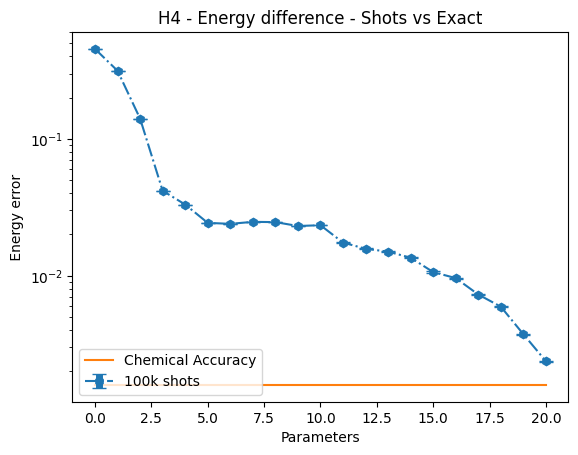

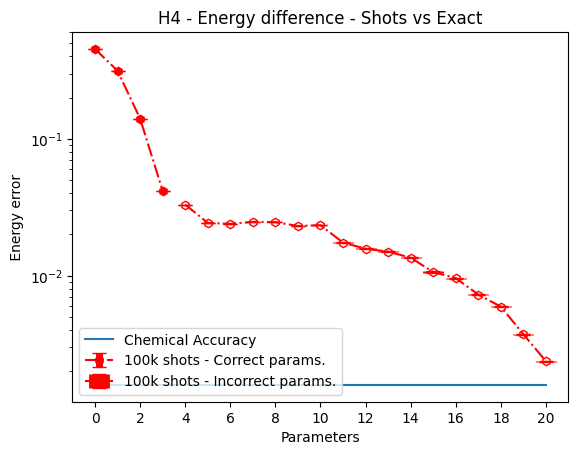

In [206]:
E_100k_C = np.array([-1.4301166353125268,-1.56893264410326,  -1.7429306173257348, -1.8407599552637113,-1.8480257195497676, -1.8595394484317729,
                    -1.8593054198388779, -1.858082549746958, -1.8603721835547888, -1.8588156781320515, -1.8589558766711012, -1.8579581826633402,
                    -1.8614120239223748, -1.8586993573790145, -1.8583614506275075, -1.8547483442985904, -1.8569429320329416, -1.858606948338374,
                    -1.857500297712233, -1.8571582469783505, -1.8590275331588864]) #COBYLA 100k shots - 0th iteration
 
E_100k1_C = np.array([-1.431397442477029,-1.569980535930573,-1.7431484472706178,-1.8399113866966819, -1.8497523596529277, -1.858009660908435,
                     -1.8602167615803566,-1.8563335478097778, -1.8540119178609293, -1.8559054967135349, -1.8551986794997666,-1.8571539227047134,
                    -1.8574377597950606, -1.8593294739649517, -1.8571378410258261,-1.85796591015194, -1.8595117479572458, -1.8585180245409592,
                      -1.857433238197289, -1.8564555441013597, -1.858540280541006        ]) #COBYLA 100k shots - 1st iteration

E_100k2_C = np.array([-1.4302120731930024,-1.5681842787972204, -1.7419410257909087,-1.834454316062963,-1.84798580412481, -1.856639158937607,
                      -1.8535038806397464, -1.8535427605690635,-1.8553600611572663,-1.8608313551636706,-1.8597466493631973, -1.8575530026801748,
                       -1.8583293264881897, -1.8582408758748454, -1.8598307634555031, -1.8596517362745704, -1.8585572371671597, -1.8617664349164398,
                        -1.8631551157717232, -1.8622165846951926, -1.8654501374271475   ]) #COBYLA 100k shots - 2nd iteration

E_100k3_C = np.array([-1.4294056615815185,-1.5695044257762687,-1.741492686314566, -1.8396550006250751, -1.8483528854038562,-1.858093935611526,
                      -1.858629259155871,-1.8551872028027734,-1.859182209395096, -1.8588228882279247,-1.8573481574539064,-1.8574728495211077,
                        -1.8608176979991837,-1.8582592234791973, -1.8592633567785677, -1.8597014321155054, -1.8596348716879927, -1.8609288914982962,
                        -1.8592091158912802,-1.8599275873899255,-1.861183159048062        ]) #COBYLA 100k shots - 3rd iteration

E_100k4_C = np.array([ -1.4288212305871828,-1.5687098812744442,-1.7424914429898088,-1.838493917112561,  -1.8490218878533724,-1.859188110100795,
                      -1.8561509460873868,-1.8579169924902632, -1.8579305587800314,-1.8579387266131584, -1.8589767640109747, -1.8594119880392348,
                        -1.8586904822463004, -1.8578257244843057, -1.8547328719716594, -1.8567361744706201,-1.858488888257592, -1.8576469850657975,
                          -1.8592603740581626, -1.858504856670289, -1.8543375715213657        ]) #COBYLA 100k shots - 4th iteration

FCI = np.full(shape=21, fill_value= -1.885124904189219) #FCI Energy

data_sets = np.array([E_100k_C-FCI, E_100k1_C-FCI, E_100k2_C-FCI, E_100k3_C-FCI, E_100k4_C-FCI])
print(data_sets)

E_100k_mean_C = np.mean(data_sets, axis=0)  # mean for each of the 21 values
E_100k_variance_C = np.var(data_sets, axis=0)  # variance for each of the 21 values

# Print results
print("Means of the 21 values across datasets:")
print(means)

print("Variances of the 21 values across datasets:")
print(variances)


params = np.linspace(0, 20, 21)

Error_100k = abs(E_100k_mean - FCI)

#Error_10k = abs(E_10k_mean - FCI)

#Error_exact = abs(E_exact - FCI)

chem_accuracy = np.full(fill_value=1.59e-3, shape=21)


import matplotlib.pyplot as plt
#plt.plot(params, Error_exact, '-o', label = 'Exact')

#plt.errorbar(params, Error_10k, yerr=E_10k_variance, fmt='-.v', elinewidth=2, capsize=5, label = '10k shots')
plt.errorbar(params, Error_100k, yerr=E_100k_variance, fmt='-.h', elinewidth=5, capsize=5, label = '100k shots')
plt.plot(params, chem_accuracy, '-', label = 'Chemical Accuracy')
plt.legend(loc = 'lower left')
plt.yscale('log')
#plt.xlim(12, 20)
#plt.ylim(1e-3, 1e-1)
plt.xlabel('Parameters')
plt.title('H4 - Energy difference - Shots vs Exact')
plt.ylabel(' Energy error ')
plt.show()


#plt.plot(params, Error_exact, '-o', label = 'Exact')
#plt.errorbar(params[:4], Error_10k[:4], yerr=E_10k_variance[:4], fmt='-.v', color='k',elinewidth=2, capsize=5, label='10k shots - Correct params.')
plt.errorbar(params[:4], Error_100k[:4], yerr=E_100k_variance[:4], fmt='-.h', color= 'r',elinewidth=5, capsize=5, label='100k shots - Correct params.')

plt.plot(params, chem_accuracy, '-', label = 'Chemical Accuracy')
#plt.errorbar(params[4:], Error_10k[4:], yerr=E_10k_variance[4:], fmt='-.v', elinewidth=2,  color= 'k',capsize=5,markerfacecolor='none', label='10k shots - Incorrect params.')
plt.errorbar(params[4:], Error_100k[4:], yerr=E_100k_variance[4:], fmt='-.h', elinewidth=15, color = 'r',capsize=5,markerfacecolor='none', label='100k shots - Incorrect params.')
plt.xticks(np.arange(0, 22, 2)) 
plt.legend(loc = 'lower left')
plt.yscale('log')
plt.xlabel('Parameters')
plt.title('H4 - Energy difference - Shots vs Exact')
plt.ylabel(' Energy error ')
plt.show()